In [1]:
## Train Keras CNN Model on AWS Sagemaker

In [1]:
import os
import sys

import numpy as np
import sagemaker
from sagemaker.tensorflow import TensorFlow
import tensorflow as tf
from tensorflow import keras
import boto3
from botocore.exceptions import ClientError

In [2]:
# Our SM jobs will use this bucket
SM_WORKING_S3_BUCKET = "tensorflow-sagemaker-0028"

SM_SESSION = sagemaker.Session(default_bucket=SM_WORKING_S3_BUCKET)
SM_ROLE = sagemaker.get_execution_role()

print (SM_SESSION)
print (SM_ROLE)

TOPDIR = os.getcwd()

EPOCHS = 10
BATCH_SIZE = 256
LEARNING_RATE = 0.01

S3_OUTPUT_URI=f"s3://{SM_WORKING_S3_BUCKET}"


arn:aws:iam::062107626262:role/sagemaker-access


In [3]:
# Loading and Saving the dataset

fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

os.makedirs("./data", exist_ok = True)

np.savez('./data/training', image=train_images, label=train_labels)
np.savez('./data/validation', image=test_images, label=test_labels)

4423680/4422102 [==============================] - 0s 0us/step


In [4]:
# Upload the dataset to S3 bucket

def upload_file(file_name, bucket, object_name=None):
    s3_client = boto3.client('s3')
    try:
        response = s3_client.upload_file(file_name, bucket, object_name)
    except ClientError as e:
        logging.error(e)
        return False
    return True

upload_file('./data/training.npz', SM_WORKING_S3_BUCKET, 'data/training.npz')
upload_file('./data/validation.npz', SM_WORKING_S3_BUCKET, 'data/validation.npz')

True

In [5]:
# Setting up parameters for Training the model.

model_dir = '/opt/ml/model'

training_input_path = os.path.join('s3://',SM_WORKING_S3_BUCKET, 'data/training.npz')
validation_input_path = os.path.join('s3://',SM_WORKING_S3_BUCKET, 'data/validation.npz')

train_instance_type = 'ml.m4.xlarge'
#train_instance_type = 'local'

# Path is relative to the src_dir
hyperparameters = {'epochs' : EPOCHS,
                   'batch-size' : BATCH_SIZE,
                   'learning-rate' : LEARNING_RATE
                  }

inputs = {'training': training_input_path, 'validation': validation_input_path}
print(inputs)

{'training': 's3://tensorflow-sagemaker-0028/data/training.npz', 'validation': 's3://tensorflow-sagemaker-0028/data/validation.npz'}


In [6]:
!pygmentize fashionmnist.py

import sys
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
import argparse
import subprocess



if __name__ == '__main__':
        
    parser = argparse.ArgumentParser()

    parser.add_argument('--epochs', type=int, default=15)
    parser.add_argument('--learning-rate', type=float, default=0.01)
    parser.add_argument('--batch-size', type=int, default=128)
    parser.add_argument('--gpu-count', type=int, default=os.environ['SM_NUM_GPUS'])
    parser.add_argument('--model-dir', type=str, default=os.environ['SM_MODEL_DIR'])
    parser.add_argument('--training', type=str, default=os.environ['SM_CHANNEL_TRAINING'])
    parser.add_argument('--validation', type=str, default=os.environ['SM_CHANNEL_VALIDATION'])

    args, _ = parser.parse_known_args()
    
    epochs     = args.epochs
    lr         = args.learning_rate
    batch_size = args.batch_size
    gpu_count  = args.gpu_count
    model_dir  = args.model_dir
    training_dir   = args.training
    va

In [7]:
tf_estimator = TensorFlow(entry_point='fashionmnist.py', 
                          role=SM_ROLE,
                          output_path=S3_OUTPUT_URI,
                          train_instance_count=1, 
                          train_instance_type=train_instance_type,
                          framework_version='2.1.0',
                          py_version='py3',
                          hyperparameters=hyperparameters
                         )

In [8]:
tf_estimator.fit(inputs)

2020-05-15 09:23:46 Starting - Starting the training job...
2020-05-15 09:23:47 Starting - Launching requested ML instances......
2020-05-15 09:25:12 Starting - Preparing the instances for training......
2020-05-15 09:26:05 Downloading - Downloading input data...
2020-05-15 09:26:31 Training - Downloading the training image..2020-05-15 09:26:55,745 sagemaker-containers INFO     Imported framework sagemaker_tensorflow_container.training
2020-05-15 09:26:55,752 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2020-05-15 09:26:56,206 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2020-05-15 09:26:56,224 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2020-05-15 09:26:56,241 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2020-05-15 09:26:56,255 sagemaker-containers INFO     Invoking user script

Training Env:

{
    "additional_framework_parameters": {},
    "channel_input_d


2020-05-15 09:26:51 Training - Training image download completed. Training in progress.#015  256/60000 [..............................] - ETA: 2s - loss: 0.3946 - accuracy: 0.8594#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 1792/60000 [..............................] - ETA: 1s - loss: 0.3900 - accuracy: 0.8599#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 3328/60000 [>......

#015  256/60000 [..............................] - ETA: 2s - loss: 0.3733 - accuracy: 0.8906#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 1792/60000 [..............................] - ETA: 2s - loss: 0.2939 - accuracy: 0.9029#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 3328/60000 [>.............................] - ETA: 1s - loss: 0.3028 - accuracy: 0.8951#010#010#010#010#010

#015  256/60000 [..............................] - ETA: 2s - loss: 0.2027 - accuracy: 0.9141#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 1280/60000 [..............................] - ETA: 3s - loss: 0.2313 - accuracy: 0.9164#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 2816/60000 [>.............................] - ETA: 2s - loss: 0.2544 - accuracy: 0.9112#010#010#010#010#010


2020-05-15 09:27:34 Uploading - Uploading generated training model
2020-05-15 09:27:34 Completed - Training job completed
Training seconds: 89
Billable seconds: 89


In [9]:
## Deploy your model

import time

tf_endpoint_name = 'tf-fmnist-'+time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())

tf_predictor = tf_estimator.deploy(initial_instance_count=1,
                         instance_type='ml.m4.xlarge',
                         endpoint_name=tf_endpoint_name)

-----------!

Predicted labels are: [7 9 8 0 7]


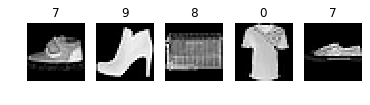

In [10]:
%matplotlib inline
import random
import matplotlib.pyplot as plt

num_samples = 5
indices = random.sample(range(test_images.shape[0] - 1), num_samples)
images = test_images[indices]/255
labels = test_labels[indices]

# datamain= images.reshape(num_samples, 28, 28, 1)
# data = json.dumps(datamain.tolist())
# print(datamain.type)

# json_file = open('predictfin.json', 'w')
# json_file.write(data)
# json_file.close()


for i in range(num_samples):
    plt.subplot(1,num_samples,i+1)
    plt.imshow(images[i].reshape(28, 28), cmap='gray')
    plt.title(labels[i])
    plt.axis('off')

prediction = tf_predictor.predict(images.reshape(num_samples, 28, 28, 1))['predictions']
prediction = np.array(prediction)
predicted_label = prediction.argmax(axis=1)
print('Predicted labels are: {}'.format(predicted_label))

In [ ]:
SM_SESSION.delete_endpoint(endpoint_name=tf_endpoint_name)

In [25]:
# This is to create an Endpoint from existing Endpoint Configurations.

import boto3

client = boto3.client('sagemaker')

response = client.create_endpoint(
    EndpointName='tf-fmnist-2020-05-13-13-58-59',
    EndpointConfigName='tf-fmnist-2020-05-13-13-58-59'
)